# Model training

For this demo we'll use the freely available Statlog (German Credit Data) Data Set, which can be downloaded from [Kaggle](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)). This dataset classifies customers based on a set of attributes into two credit risk groups - good or bad. The majority of the attributes in this data set are categorical, and they are symbolically encoded. For example, attribute 1 represents the status of an existing checking account and can take one of the following values:

A11 : ... < 0 DM

A12 : 0 <= ... < 200 DM

A13 : ... >= 200 DM / salary assignments for at least 1 year

A14 : no checking account

A comprehensive list of all attributes and symbol codes is given in the [document](https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc) that accompanies the original dataset. 

The data we use in this demo has also been balanced and upsampled (see the [Data Generation](./data_generation.ipynb) notebook for reference).

## Seting up and connecting to Ray


Let's start by loading all the libraries needed for the notebook and by setting up default data paths.


In [1]:
import os
import ray
import glob
import eli5

import xgboost_ray as xgbr
import xgboost as xgb
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from ray import tune

DATA_ROOT = os.path.join("/mnt/data", os.environ["DOMINO_PROJECT_NAME"], "data") 
MODEL_ROOT = "/mnt/artifacts"
TUNE_ROOT = os.path.join("/mnt/data", os.environ["DOMINO_PROJECT_NAME"], "ray_results")

In this demo we'll use a dataset of a modest size (approx. 700 MB). Unfortunately, the standard Python libraries for data processing and machine learning Pandas and NumPy have never been designed with large datasets in mind. They rely on being able to fit the entire data in-memory with Pandas data frames having a hard theoretical limit of 100GB. In practice, the amount of data these libraries can handle is also restricted by the amount of physical memory available to the container that runs them, thus they'll have challenges handling even the 700 MB needed for our demo dataset. Trying to load our training data into a simple Pandas data frame using the code below will likely crash the Jupyter kernel.

``` 
# Do not run this code - it will likely crash the Jupyter kernel 
# (depending on the HW tier running the kernel)

import pandas as pd
import glob
import os

all_files = glob.glob(DATA_ROOT + "/train_data_*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

training_df = pd.concat(li, axis=0, ignore_index=True)
training_df.head()
```

To circumvent these restrictions Domino provides support for a number of industry-standard distributed computing frameworks like Ray, Dask, and Spark. In this demo we will use [On-Demand Ray](https://docs.dominodatalab.com/en/latest/user_guide/d13903/on-demand-ray-overview/). 

Ray is a general framework that enables you to quickly parallelize existing Python code, but it is also talked about as a "framework for building frameworks". Indeed, there are a growing number of domain-specific libraries that work on top of Ray.

![Ray](./images/ray.png)

For example:

* RaySGD - a library for distributed deep learning, which provides wrappers around PyTorch and TensorFlow
* RLlib - a library for reinforcement learning, which also natively supports TensorFlow, TensorFlow Eager, and PyTorch
* RayServe - a scalable, model-serving library
* Ray Tune - a hyperparameter optimization framework, most commonly used for deep and reinforcement learning

In this demo we'll use [Ray Tune](https://docs.ray.io/en/latest/tune/index.html) for hyperparameter optimisation and [XGBoost on Ray](https://github.com/ray-project/xgboost_ray) for model training.

In [2]:
# We'll set up Ray for 2 workers, 4 CPUs each (12 CPUs in total, counting the head node).

RAY_ACTORS = 3
RAY_CPUS_PER_ACTOR = 4

Let's connect to Ray.

In [3]:
if ray.is_initialized() == False:
    service_host = os.environ["RAY_HEAD_SERVICE_HOST"]
    service_port = os.environ["RAY_HEAD_SERVICE_PORT"]
    ray.init(f"ray://{service_host}:{service_port}")

Let's confirm we have the expected cluster configuration.

In [4]:
ray.nodes()

[{'NodeID': '735b638ad6783396c27bc91c8c70303a71aa339e20506d9426010a8e',
  'Alive': True,
  'NodeManagerAddress': '100.64.94.87',
  'NodeManagerHostname': 'ray-68372b50eb5aa754a7853b5c-ray-head-0',
  'NodeManagerPort': 2385,
  'ObjectManagerPort': 2384,
  'ObjectStoreSocketName': '/tmp/ray/session_2025-05-28_08-27-21_384572_1/sockets/plasma_store',
  'RayletSocketName': '/tmp/ray/session_2025-05-28_08-27-21_384572_1/sockets/raylet',
  'MetricsExportPort': 64858,
  'NodeName': '100.64.94.87',
  'alive': True,
  'Resources': {'object_store_memory': 4753798348.0,
   'node:100.64.94.87': 1.0,
   'memory': 9507596699.0}},
 {'NodeID': 'd1d68143ae68cec136cb72f80971f1a494bac43180b10ddf1def7091',
  'Alive': True,
  'NodeManagerAddress': '100.64.57.8',
  'NodeManagerHostname': 'ray-68372b50eb5aa754a7853b5c-ray-worker-2',
  'NodeManagerPort': 2385,
  'ObjectManagerPort': 2384,
  'ObjectStoreSocketName': '/tmp/ray/session_2025-05-28_08-27-21_384572_1/sockets/plasma_store',
  'RayletSocketName': '/t

Now let's create a list of all the shards for our training, validation, and test sets.

In [5]:
train_files = glob.glob(os.path.join(DATA_ROOT, "train_data*"))
val_files = glob.glob(os.path.join(DATA_ROOT, "validation_data*"))

test_file = os.path.join(DATA_ROOT, "test_data.csv")

target_col = "credit"

XGBoost-Ray provides a drop-in replacement for XGBoost's train function. To pass data, instead of using xgb.DMatrix we will have to use xgboost_ray.RayDMatrix. The RayDMatrix lazy loads data and stores it sharded in the Ray object store. The Ray XGBoost actors then access these shards to run their training on. Let's wrap our training, validation, and test sets into RayDMatrix objects.

In [6]:
# Although it is possible to specify the number of Actors when initializing the RayDMatrix, it is not necessary,
#  and can cause a conflict if different from the number of Actors chosen for training.

rdm_train = xgbr.RayDMatrix(train_files, label=target_col)
rdm_val = xgbr.RayDMatrix(val_files, label=target_col)

df_test = pd.read_csv(test_file)
rdm_test = xgbr.RayDMatrix(df_test, label=target_col)

In [7]:
# This function verifies whether the data will support splitting into a given number of shards.
# We use this to validate that our splits are compatible with the selected Ray cluster configuraiton (i.e. number of Ray nodes)

rdm_train.assert_enough_shards_for_actors(len(train_files))
rdm_train.assert_enough_shards_for_actors(len(val_files))

In [8]:
print("Will the read be distributed?", rdm_train.distributed)
print("Has any data been read yet?", rdm_train.loaded) # Remember, lazy loading

Will the read be distributed? True
Has any data been read yet? False


## Model training

Let's first try to train a single model in order to validate our setup. Feel free to switch to the Ray Web UI tab and observe the distribution of workload among the individual Ray nodes.

A few things to note:

* We are using “binary:logistic” – logistic regression for binary classification (*credit* is in {0,1}), which outputs probability
* We are calculating both logloss and error as evaluation metrics. They don't impact the model fitting
* We are passing the cluster topology via the xgb_ray_params objects so that the workload can be correctly distributed


In [9]:
# Set a few hyperparameters to specific values
param = {
    "seed":1234,
    "max_depth":3,
    "eta":0.1,
    "objective": "binary:logistic",
    "eval_metric": ["logloss", "error"]
}

xgb_ray_params = xgbr.RayParams(
    num_actors=RAY_ACTORS,
    cpus_per_actor=RAY_CPUS_PER_ACTOR
)

# Train the model
evals_result = {}

bst = xgbr.train(
    param,
    rdm_train,
    num_boost_round=50,
    verbose_eval=True,
    evals_result=evals_result,
    evals =[(rdm_train, "train"), (rdm_val, "val")],
    ray_params=xgb_ray_params
)

print("Final training error: {:.4f}".format(evals_result["train"]["error"][-1]))
print("Final validation error: {:.4f}".format(evals_result["val"]["error"][-1]))

/opt/conda/lib/python3.9/site-packages/xgboost_ray/util.py:89: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
Use get_node_id() instead
  current_node_id = ray.get_runtime_context().node_id.hex()
(_wrapped pid=451) 2025-05-28 08:32:30,160	INFO main.py:1047 -- [RayXGBoost] Created 3 new actors (3 total actors). Waiting until actors are ready for training.
(_wrapped pid=451) 2025-05-28 08:32:41,254	INFO main.py:1092 -- [RayXGBoost] Starting XGBoost training.
(_RemoteRayXGBoostActor pid=172, ip=100.64.30.186) [08:32:41] task [xgboost.ray]:137937733779520 got new rank 0
(_RemoteRayXGBoostActor pid=172, ip=100.64.57.102) [08:32:41] task [xgboost.ray]:140494167802400 got new rank 1
(_RemoteRayXGBoostActor pid=212, ip=100.64.57.8) [08:32:41] task [xgboost.ray]:140396623507952 got new rank 2


(_wrapped pid=451) [0]	train-logloss:0.65890	train-error:0.22747	val-logloss:0.65631	val-error:0.20883
(_wrapped pid=451) [1]	train-logloss:0.63109	train-error:0.22331	val-logloss:0.62514	val-error:0.20021
(_wrapped pid=451) [2]	train-logloss:0.60870	train-error:0.22340	val-logloss:0.60081	val-error:0.20959
(_wrapped pid=451) [3]	train-logloss:0.58690	train-error:0.18629	val-logloss:0.57680	val-error:0.15792
(_wrapped pid=451) [4]	train-logloss:0.56898	train-error:0.19034	val-logloss:0.55650	val-error:0.16499
(_wrapped pid=451) [5]	train-logloss:0.55210	train-error:0.20139	val-logloss:0.53913	val-error:0.17972
(_wrapped pid=451) [6]	train-logloss:0.53646	train-error:0.18746	val-logloss:0.52258	val-error:0.16193
(_wrapped pid=451) [7]	train-logloss:0.52353	train-error:0.18899	val-logloss:0.50922	val-error:0.16659
(_wrapped pid=451) [8]	train-logloss:0.51097	train-error:0.17833	val-logloss:0.49647	val-error:0.15485
(_wrapped pid=451) [9]	train-logloss:0.50000	train-error:0.16964	val-logl

(_wrapped pid=451) 2025-05-28 08:33:11,836	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(_wrapped pid=451) [32]	train-logloss:0.35040	train-error:0.11787	val-logloss:0.33605	val-error:0.10798
(_wrapped pid=451) [33]	train-logloss:0.34684	train-error:0.11448	val-logloss:0.33241	val-error:0.10723
(_wrapped pid=451) [34]	train-logloss:0.34377	train-error:0.11517	val-logloss:0.32920	val-error:0.10568
(_wrapped pid=451) [35]	train-logloss:0.33971	train-error:0.11360	val-logloss:0.32577	val-error:0.10412
(_wrapped pid=451) [36]	train-logloss:0.33605	train-error:0.10761	val-logloss:0.32224	val-error:0.10097
(_wrapped pid=451) [37]	train-logloss:0.33335	train-error:0.10382	val-logloss:0.31979	val-error:0.09627
(_wrapped pid=451) [38]	train-logloss:0.32945	train-error:0.10460	val-logloss:0.31619	val-error:0.09786
(_wrapped pid=451) [39]	train-logloss:0.32654	train-error:0.10505	val-logloss:0.31294	val-error:0.09787
(_wrapped pid=451) [40]	train-logloss:0.32362	train-error:0.10278	val-logloss:0.31013	val-error:0.09549
(_wrapped pid=451) [41]	train-logloss:0.32094	train-error:0.1040

Now that we've confirmed the pipeline we can move onto performing some hyperparameter tuning for finding an optimal model.

## Hyperparameter tuning

Hyperparameter tuning requires training many copies of a model, each with a different set of hyperparameters, and seeing which one performs the best. Each time we train a model, that is one trial. To do this in our Ray cluster, we can specify what resources to use:

* Required CPU, Memory, and/or GPU per trial
* Where to store intermediate results

The `xgboost_ray` library includes a built-in method for generating a `PlacementGroupFactory` to pass to Ray Tune, based on the `RayParams` object used for XGBoost training. Resources can also be requested in a simpler dictionary format, e.g. `{"cpu": 2.0}`. As described in the [Tune docs](https://docs.ray.io/en/latest/tune/tutorials/tune-resources.html), by default Ray Tune will schedule N concurrent trials, using 1 CPU per trial, where N is the total number of CPUs available in the cluster.

In [10]:
# Get the placement group factory to pass to Ray Tune
# Notice how the tune resources are 1 CPU greater!
xgb_tune_resources = xgb_ray_params.get_tune_resources()
print(f"We will pass a {type(xgb_tune_resources)} to Ray Tune.")
print(f"It will request {xgb_tune_resources.required_resources} per trial.")
print(f"The cluster has {ray.cluster_resources()['CPU']} CPU total.")

We will pass a <class 'ray.tune.execution.placement_groups.PlacementGroupFactory'> to Ray Tune.
It will request {'CPU': 12.0} per trial.
The cluster has 12.0 CPU total.


In [11]:
print("Saving intermediate tune results to", TUNE_ROOT)

Saving intermediate tune results to /mnt/data/Demo-Credit-Default-Model/ray_results


(_wrapped pid=451) 2025-05-28 08:33:25,394	INFO main.py:1587 -- [RayXGBoost] Finished XGBoost training on training data with total N=2,100,000 in 56.26 seconds (44.13 pure XGBoost training time).


In this demo we will use a very simple search strategy called *a grid search*. This involves searching over a predefined grid of hyperparameter choices - and it's easy to imaging writing a simple for loop to implement it. However, for $n$ choices each of $k$ hyperparameters, a full grid search requires $O(n^k)$ trials and quickly becomes prohibitively expensive.

Ray Tune provides much more sophisticated options for optimization. Instead of pre-defining a fixed grid to search over, Ray Tune allows specifying a [search space](https://docs.ray.io/en/releases-1.11.0/tune/key-concepts.html#search-spaces) with distributions of parameters. The number of trials over the search space is specified at a later stage in the `run()` function.

In [12]:
config = {
    "seed": 1234,
    "eta": tune.loguniform(3e-3, 3e-1),
    "max_depth": tune.randint(2, 6),
    "objective": "binary:logistic",
    "eval_metric": ["logloss", "error"]
}

For each trial, a config dictionary like the one we just defined, with the single value for each hyperparameter chosen for that trial, will be passed into a [trainable](https://docs.ray.io/en/releases-1.11.0/tune/key-concepts.html#search-algorithms) that we define and pass to Ray Tune. Below we have defined such a function to wrap training a single XGBoost model on Ray.

In [13]:
def my_trainer(config):
    evals_result = {}
    bst = xgbr.train(
        params=config,
        dtrain=rdm_train,
        num_boost_round=50,
        evals_result=evals_result,
        evals=[(rdm_train, "train"), (rdm_val, "val")],
        ray_params=xgb_ray_params
    )
    bst.save_model("model.xgb") # This will go into the TUNE_ROOT directory

Finally, we can now run our trials. Here we bring together the previous few sections:

* The training function
* The search space defined in the config
* The resources per trial and results location

We control the number of trials over the search space via the `num_samples` argument (currently set to 10). We also rank the models based on the lowest validation set error.

In [14]:
analysis = tune.run(
    my_trainer,
    config=config,
    resources_per_trial=xgb_tune_resources,
    local_dir=TUNE_ROOT,
    metric="val-error",
    mode="min",
    num_samples=10,
    verbose=1,
    progress_reporter=tune.JupyterNotebookReporter(overwrite=True)
)

(run pid=451) UserWarning: The `local_dir` argument of `Experiment is deprecated. Use `storage_path` or set the `TUNE_RESULT_DIR` environment variable instead.
(_RemoteRayXGBoostActor pid=298, ip=100.64.30.186) [08:33:38] task [xgboost.ray]:132081365881376 got new rank 0
(_RemoteRayXGBoostActor pid=253, ip=100.64.57.102) [08:33:38] task [xgboost.ray]:124468074287792 got new rank 1
(_RemoteRayXGBoostActor pid=295, ip=100.64.57.8) [08:33:38] task [xgboost.ray]:138193990697504 got new rank 2


(my_trainer pid=254, ip=100.64.30.186) [0]	train-logloss:0.68575	train-error:0.20367	val-logloss:0.68546	val-error:0.19787
(my_trainer pid=254, ip=100.64.30.186) [1]	train-logloss:0.67859	train-error:0.20367	val-logloss:0.67797	val-error:0.19787
(my_trainer pid=254, ip=100.64.30.186) [2]	train-logloss:0.67181	train-error:0.19528	val-logloss:0.67061	val-error:0.18459
(my_trainer pid=254, ip=100.64.30.186) [3]	train-logloss:0.66532	train-error:0.18766	val-logloss:0.66350	val-error:0.17522
(my_trainer pid=254, ip=100.64.30.186) [4]	train-logloss:0.65876	train-error:0.19587	val-logloss:0.65670	val-error:0.18450
(my_trainer pid=254, ip=100.64.30.186) [5]	train-logloss:0.65255	train-error:0.19508	val-logloss:0.64999	val-error:0.18378
(my_trainer pid=254, ip=100.64.30.186) [6]	train-logloss:0.64662	train-error:0.18546	val-logloss:0.64346	val-error:0.17448
(my_trainer pid=254, ip=100.64.30.186) [7]	train-logloss:0.64061	train-error:0.18440	val-logloss:0.63723	val-error:0.16994
(my_trainer pid=

(my_trainer pid=254, ip=100.64.30.186) 2025-05-28 08:34:09,273	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=254, ip=100.64.30.186) [32]	train-logloss:0.53154	train-error:0.17372	val-logloss:0.52085	val-error:0.15731
(my_trainer pid=254, ip=100.64.30.186) [33]	train-logloss:0.52828	train-error:0.17136	val-logloss:0.51741	val-error:0.15417
(my_trainer pid=254, ip=100.64.30.186) [34]	train-logloss:0.52483	train-error:0.17136	val-logloss:0.51369	val-error:0.15496
(my_trainer pid=254, ip=100.64.30.186) [35]	train-logloss:0.52165	train-error:0.17304	val-logloss:0.51045	val-error:0.15727
(my_trainer pid=254, ip=100.64.30.186) [36]	train-logloss:0.51818	train-error:0.17316	val-logloss:0.50685	val-error:0.15652
(my_trainer pid=254, ip=100.64.30.186) [37]	train-logloss:0.51518	train-error:0.16854	val-logloss:0.50367	val-error:0.15104
(my_trainer pid=254, ip=100.64.30.186) [38]	train-logloss:0.51198	train-error:0.16785	val-logloss:0.50022	val-error:0.15104
(my_trainer pid=254, ip=100.64.30.186) [39]	train-logloss:0.50908	train-error:0.16729	val-logloss:0.49708	val-error:0.15025
(my_trai

(_RemoteRayXGBoostActor pid=480, ip=100.64.30.186) [08:34:29] task [xgboost.ray]:132468357202464 got new rank 0
(_RemoteRayXGBoostActor pid=376, ip=100.64.57.102) [08:34:29] task [xgboost.ray]:128440824697376 got new rank 1
(_RemoteRayXGBoostActor pid=378, ip=100.64.57.8) [08:34:29] task [xgboost.ray]:138737094808096 got new rank 2


(my_trainer pid=254, ip=100.64.30.186) [0]	train-logloss:0.68700	train-error:0.22747	val-logloss:0.68655	val-error:0.20883
(my_trainer pid=254, ip=100.64.30.186) [1]	train-logloss:0.68107	train-error:0.22747	val-logloss:0.68018	val-error:0.20883
(my_trainer pid=254, ip=100.64.30.186) [2]	train-logloss:0.67552	train-error:0.22331	val-logloss:0.67400	val-error:0.20021
(my_trainer pid=254, ip=100.64.30.186) [3]	train-logloss:0.67016	train-error:0.22331	val-logloss:0.66803	val-error:0.20021
(my_trainer pid=254, ip=100.64.30.186) [4]	train-logloss:0.66471	train-error:0.22331	val-logloss:0.66217	val-error:0.20021
(my_trainer pid=254, ip=100.64.30.186) [5]	train-logloss:0.65966	train-error:0.22331	val-logloss:0.65647	val-error:0.20021
(my_trainer pid=254, ip=100.64.30.186) [6]	train-logloss:0.65476	train-error:0.21686	val-logloss:0.65101	val-error:0.19396
(my_trainer pid=254, ip=100.64.30.186) [7]	train-logloss:0.65002	train-error:0.21114	val-logloss:0.64566	val-error:0.18773
(my_trainer pid=

(my_trainer pid=254, ip=100.64.30.186) 2025-05-28 08:34:59,928	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=254, ip=100.64.30.186) [33]	train-logloss:0.55842	train-error:0.18677	val-logloss:0.54622	val-error:0.17124
(my_trainer pid=254, ip=100.64.30.186) [34]	train-logloss:0.55569	train-error:0.18689	val-logloss:0.54339	val-error:0.16732
(my_trainer pid=254, ip=100.64.30.186) [35]	train-logloss:0.55292	train-error:0.18747	val-logloss:0.54045	val-error:0.16736
(my_trainer pid=254, ip=100.64.30.186) [36]	train-logloss:0.55049	train-error:0.18747	val-logloss:0.53797	val-error:0.16736
(my_trainer pid=254, ip=100.64.30.186) [37]	train-logloss:0.54800	train-error:0.18248	val-logloss:0.53538	val-error:0.16197
(my_trainer pid=254, ip=100.64.30.186) [38]	train-logloss:0.54564	train-error:0.18722	val-logloss:0.53289	val-error:0.16815
(my_trainer pid=254, ip=100.64.30.186) [39]	train-logloss:0.54306	train-error:0.17718	val-logloss:0.53015	val-error:0.15959
(my_trainer pid=254, ip=100.64.30.186) [40]	train-logloss:0.54064	train-error:0.17850	val-logloss:0.52775	val-error:0.16111
(my_trai

(_RemoteRayXGBoostActor pid=663, ip=100.64.30.186) [08:35:19] task [xgboost.ray]:139637205246160 got new rank 0
(_RemoteRayXGBoostActor pid=501, ip=100.64.57.102) [08:35:19] task [xgboost.ray]:140568814207616 got new rank 1
(_RemoteRayXGBoostActor pid=498, ip=100.64.57.8) [08:35:19] task [xgboost.ray]:124583643739472 got new rank 2


(my_trainer pid=254, ip=100.64.30.186) [0]	train-logloss:0.66293	train-error:0.30285	val-logloss:0.66114	val-error:0.29079
(my_trainer pid=254, ip=100.64.30.186) [1]	train-logloss:0.63867	train-error:0.26686	val-logloss:0.63478	val-error:0.24841
(my_trainer pid=254, ip=100.64.30.186) [2]	train-logloss:0.61807	train-error:0.25756	val-logloss:0.61241	val-error:0.23594
(my_trainer pid=254, ip=100.64.30.186) [3]	train-logloss:0.59991	train-error:0.26062	val-logloss:0.59309	val-error:0.24222
(my_trainer pid=254, ip=100.64.30.186) [4]	train-logloss:0.58348	train-error:0.24344	val-logloss:0.57686	val-error:0.22594
(my_trainer pid=254, ip=100.64.30.186) [5]	train-logloss:0.56976	train-error:0.24434	val-logloss:0.56191	val-error:0.22265
(my_trainer pid=254, ip=100.64.30.186) [6]	train-logloss:0.55782	train-error:0.24264	val-logloss:0.55034	val-error:0.22423
(my_trainer pid=254, ip=100.64.30.186) [7]	train-logloss:0.54672	train-error:0.22738	val-logloss:0.53877	val-error:0.21805
(my_trainer pid=

(my_trainer pid=254, ip=100.64.30.186) 2025-05-28 08:35:49,784	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=254, ip=100.64.30.186) [33]	train-logloss:0.39503	train-error:0.14698	val-logloss:0.38406	val-error:0.13692
(my_trainer pid=254, ip=100.64.30.186) [34]	train-logloss:0.39282	train-error:0.15071	val-logloss:0.38188	val-error:0.14236
(my_trainer pid=254, ip=100.64.30.186) [35]	train-logloss:0.38995	train-error:0.14676	val-logloss:0.37858	val-error:0.13923
(my_trainer pid=254, ip=100.64.30.186) [36]	train-logloss:0.38683	train-error:0.14662	val-logloss:0.37558	val-error:0.13770
(my_trainer pid=254, ip=100.64.30.186) [37]	train-logloss:0.38412	train-error:0.14012	val-logloss:0.37285	val-error:0.13145
(my_trainer pid=254, ip=100.64.30.186) [38]	train-logloss:0.38057	train-error:0.14012	val-logloss:0.36896	val-error:0.13300
(my_trainer pid=254, ip=100.64.30.186) [39]	train-logloss:0.37758	train-error:0.14033	val-logloss:0.36581	val-error:0.13376
(my_trainer pid=254, ip=100.64.30.186) [40]	train-logloss:0.37500	train-error:0.13981	val-logloss:0.36335	val-error:0.13147
(my_trai

(_RemoteRayXGBoostActor pid=849, ip=100.64.30.186) [08:36:09] task [xgboost.ray]:138537791000880 got new rank 0
(_RemoteRayXGBoostActor pid=624, ip=100.64.57.102) [08:36:09] task [xgboost.ray]:124240256781952 got new rank 1
(_RemoteRayXGBoostActor pid=617, ip=100.64.57.8) [08:36:09] task [xgboost.ray]:133768680670928 got new rank 2


(my_trainer pid=254, ip=100.64.30.186) [0]	train-logloss:0.68927	train-error:0.30285	val-logloss:0.68905	val-error:0.29079
(my_trainer pid=254, ip=100.64.30.186) [1]	train-logloss:0.68551	train-error:0.30285	val-logloss:0.68508	val-error:0.29079
(my_trainer pid=254, ip=100.64.30.186) [2]	train-logloss:0.68185	train-error:0.26686	val-logloss:0.68115	val-error:0.24841
(my_trainer pid=254, ip=100.64.30.186) [3]	train-logloss:0.67830	train-error:0.26686	val-logloss:0.67739	val-error:0.24841
(my_trainer pid=254, ip=100.64.30.186) [4]	train-logloss:0.67484	train-error:0.26686	val-logloss:0.67366	val-error:0.24841
(my_trainer pid=254, ip=100.64.30.186) [5]	train-logloss:0.67148	train-error:0.26686	val-logloss:0.67010	val-error:0.24841
(my_trainer pid=254, ip=100.64.30.186) [6]	train-logloss:0.66820	train-error:0.26686	val-logloss:0.66657	val-error:0.24841
(my_trainer pid=254, ip=100.64.30.186) [7]	train-logloss:0.66502	train-error:0.26686	val-logloss:0.66319	val-error:0.24841
(my_trainer pid=

(my_trainer pid=254, ip=100.64.30.186) 2025-05-28 08:36:40,411	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=254, ip=100.64.30.186) [33]	train-logloss:0.60113	train-error:0.25635	val-logloss:0.59503	val-error:0.24390
(my_trainer pid=254, ip=100.64.30.186) [34]	train-logloss:0.59914	train-error:0.25635	val-logloss:0.59306	val-error:0.24390
(my_trainer pid=254, ip=100.64.30.186) [35]	train-logloss:0.59723	train-error:0.25635	val-logloss:0.59098	val-error:0.24390
(my_trainer pid=254, ip=100.64.30.186) [36]	train-logloss:0.59533	train-error:0.24771	val-logloss:0.58895	val-error:0.22831
(my_trainer pid=254, ip=100.64.30.186) [37]	train-logloss:0.59343	train-error:0.25121	val-logloss:0.58708	val-error:0.23458
(my_trainer pid=254, ip=100.64.30.186) [38]	train-logloss:0.59161	train-error:0.24771	val-logloss:0.58509	val-error:0.22831
(my_trainer pid=254, ip=100.64.30.186) [39]	train-logloss:0.58979	train-error:0.25244	val-logloss:0.58329	val-error:0.23688
(my_trainer pid=254, ip=100.64.30.186) [40]	train-logloss:0.58806	train-error:0.24894	val-logloss:0.58141	val-error:0.23061
(my_trai

(_RemoteRayXGBoostActor pid=1074, ip=100.64.30.186) [08:36:59] task [xgboost.ray]:123346555687072 got new rank 0
(_RemoteRayXGBoostActor pid=707, ip=100.64.57.102) [08:36:59] task [xgboost.ray]:139358825361472 got new rank 1
(_RemoteRayXGBoostActor pid=700, ip=100.64.57.8) [08:36:59] task [xgboost.ray]:132933424112160 got new rank 2


(my_trainer pid=254, ip=100.64.30.186) [0]	train-logloss:0.66978	train-error:0.22747	val-logloss:0.66803	val-error:0.20883
(my_trainer pid=254, ip=100.64.30.186) [1]	train-logloss:0.64976	train-error:0.22331	val-logloss:0.64568	val-error:0.20021
(my_trainer pid=254, ip=100.64.30.186) [2]	train-logloss:0.63215	train-error:0.21114	val-logloss:0.62575	val-error:0.18773
(my_trainer pid=254, ip=100.64.30.186) [3]	train-logloss:0.61687	train-error:0.20921	val-logloss:0.60918	val-error:0.19475
(my_trainer pid=254, ip=100.64.30.186) [4]	train-logloss:0.60193	train-error:0.21226	val-logloss:0.59228	val-error:0.19787
(my_trainer pid=254, ip=100.64.30.186) [5]	train-logloss:0.58776	train-error:0.20220	val-logloss:0.57732	val-error:0.17826
(my_trainer pid=254, ip=100.64.30.186) [6]	train-logloss:0.57561	train-error:0.19918	val-logloss:0.56433	val-error:0.17751
(my_trainer pid=254, ip=100.64.30.186) [7]	train-logloss:0.56358	train-error:0.19717	val-logloss:0.55105	val-error:0.17207
(my_trainer pid=

(my_trainer pid=254, ip=100.64.30.186) 2025-05-28 08:37:30,154	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=254, ip=100.64.30.186) [33]	train-logloss:0.40018	train-error:0.13829	val-logloss:0.38738	val-error:0.13228
(my_trainer pid=254, ip=100.64.30.186) [34]	train-logloss:0.39643	train-error:0.13605	val-logloss:0.38387	val-error:0.12527
(my_trainer pid=254, ip=100.64.30.186) [35]	train-logloss:0.39224	train-error:0.13299	val-logloss:0.37938	val-error:0.12446
(my_trainer pid=254, ip=100.64.30.186) [36]	train-logloss:0.38901	train-error:0.13377	val-logloss:0.37599	val-error:0.12680
(my_trainer pid=254, ip=100.64.30.186) [37]	train-logloss:0.38651	train-error:0.13762	val-logloss:0.37376	val-error:0.12996
(my_trainer pid=254, ip=100.64.30.186) [38]	train-logloss:0.38276	train-error:0.13164	val-logloss:0.37022	val-error:0.12369
(my_trainer pid=254, ip=100.64.30.186) [39]	train-logloss:0.37969	train-error:0.13017	val-logloss:0.36731	val-error:0.12527
(my_trainer pid=254, ip=100.64.30.186) [40]	train-logloss:0.37675	train-error:0.13164	val-logloss:0.36451	val-error:0.12759
(my_trai

(_RemoteRayXGBoostActor pid=1258, ip=100.64.30.186) [08:37:49] task [xgboost.ray]:129224384930240 got new rank 0
(_RemoteRayXGBoostActor pid=828, ip=100.64.57.102) [08:37:49] task [xgboost.ray]:134901509808384 got new rank 1
(_RemoteRayXGBoostActor pid=822, ip=100.64.57.8) [08:37:49] task [xgboost.ray]:139690869203200 got new rank 2


(my_trainer pid=254, ip=100.64.30.186) [0]	train-logloss:0.67384	train-error:0.16109	val-logloss:0.67359	val-error:0.15954
(my_trainer pid=254, ip=100.64.30.186) [1]	train-logloss:0.65598	train-error:0.15846	val-logloss:0.65560	val-error:0.15730
(my_trainer pid=254, ip=100.64.30.186) [2]	train-logloss:0.63957	train-error:0.15996	val-logloss:0.63798	val-error:0.15415
(my_trainer pid=254, ip=100.64.30.186) [3]	train-logloss:0.62380	train-error:0.14801	val-logloss:0.62076	val-error:0.13310
(my_trainer pid=254, ip=100.64.30.186) [4]	train-logloss:0.60896	train-error:0.14662	val-logloss:0.60528	val-error:0.13550
(my_trainer pid=254, ip=100.64.30.186) [5]	train-logloss:0.59496	train-error:0.13537	val-logloss:0.59023	val-error:0.12221
(my_trainer pid=254, ip=100.64.30.186) [6]	train-logloss:0.58180	train-error:0.13904	val-logloss:0.57670	val-error:0.12686
(my_trainer pid=254, ip=100.64.30.186) [7]	train-logloss:0.56969	train-error:0.13116	val-logloss:0.56369	val-error:0.11748
(my_trainer pid=

(my_trainer pid=254, ip=100.64.30.186) 2025-05-28 08:38:20,011	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=254, ip=100.64.30.186) [32]	train-logloss:0.37508	train-error:0.09444	val-logloss:0.36143	val-error:0.08381
(my_trainer pid=254, ip=100.64.30.186) [33]	train-logloss:0.37012	train-error:0.09188	val-logloss:0.35657	val-error:0.07912
(my_trainer pid=254, ip=100.64.30.186) [34]	train-logloss:0.36544	train-error:0.09200	val-logloss:0.35132	val-error:0.07832
(my_trainer pid=254, ip=100.64.30.186) [35]	train-logloss:0.36049	train-error:0.09109	val-logloss:0.34668	val-error:0.07754
(my_trainer pid=254, ip=100.64.30.186) [36]	train-logloss:0.35574	train-error:0.09174	val-logloss:0.34202	val-error:0.07910
(my_trainer pid=254, ip=100.64.30.186) [37]	train-logloss:0.35165	train-error:0.09107	val-logloss:0.33782	val-error:0.07991
(my_trainer pid=254, ip=100.64.30.186) [38]	train-logloss:0.34714	train-error:0.08915	val-logloss:0.33358	val-error:0.07910
(my_trainer pid=254, ip=100.64.30.186) [39]	train-logloss:0.34244	train-error:0.08722	val-logloss:0.32884	val-error:0.07751
(my_trai

(_RemoteRayXGBoostActor pid=1481, ip=100.64.30.186) [08:38:40] task [xgboost.ray]:128445478314480 got new rank 0
(_RemoteRayXGBoostActor pid=908, ip=100.64.57.102) [08:38:40] task [xgboost.ray]:139008909756304 got new rank 1
(_RemoteRayXGBoostActor pid=905, ip=100.64.57.8) [08:38:40] task [xgboost.ray]:138543263610576 got new rank 2


(my_trainer pid=254, ip=100.64.30.186) [0]	train-logloss:0.67782	train-error:0.20367	val-logloss:0.67723	val-error:0.19787
(my_trainer pid=254, ip=100.64.30.186) [1]	train-logloss:0.66381	train-error:0.19621	val-logloss:0.66201	val-error:0.18534
(my_trainer pid=254, ip=100.64.30.186) [2]	train-logloss:0.65084	train-error:0.19299	val-logloss:0.64780	val-error:0.17681
(my_trainer pid=254, ip=100.64.30.186) [3]	train-logloss:0.63853	train-error:0.18695	val-logloss:0.63446	val-error:0.17609
(my_trainer pid=254, ip=100.64.30.186) [4]	train-logloss:0.62642	train-error:0.18485	val-logloss:0.62150	val-error:0.16127
(my_trainer pid=254, ip=100.64.30.186) [5]	train-logloss:0.61548	train-error:0.18318	val-logloss:0.60953	val-error:0.15888
(my_trainer pid=254, ip=100.64.30.186) [6]	train-logloss:0.60484	train-error:0.17843	val-logloss:0.59852	val-error:0.15661
(my_trainer pid=254, ip=100.64.30.186) [7]	train-logloss:0.59483	train-error:0.17923	val-logloss:0.58794	val-error:0.16207
(my_trainer pid=

(my_trainer pid=254, ip=100.64.30.186) 2025-05-28 08:39:11,411	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=254, ip=100.64.30.186) [32]	train-logloss:0.43681	train-error:0.13525	val-logloss:0.42226	val-error:0.12286
(my_trainer pid=254, ip=100.64.30.186) [33]	train-logloss:0.43239	train-error:0.13232	val-logloss:0.41746	val-error:0.11893
(my_trainer pid=254, ip=100.64.30.186) [34]	train-logloss:0.42842	train-error:0.13163	val-logloss:0.41320	val-error:0.11814
(my_trainer pid=254, ip=100.64.30.186) [35]	train-logloss:0.42476	train-error:0.13052	val-logloss:0.40962	val-error:0.11658
(my_trainer pid=254, ip=100.64.30.186) [36]	train-logloss:0.42072	train-error:0.12917	val-logloss:0.40580	val-error:0.11503
(my_trainer pid=254, ip=100.64.30.186) [37]	train-logloss:0.41673	train-error:0.12556	val-logloss:0.40171	val-error:0.11273
(my_trainer pid=254, ip=100.64.30.186) [38]	train-logloss:0.41297	train-error:0.12474	val-logloss:0.39811	val-error:0.11196
(my_trainer pid=254, ip=100.64.30.186) [39]	train-logloss:0.40946	train-error:0.12306	val-logloss:0.39464	val-error:0.11038
(my_trai

(_RemoteRayXGBoostActor pid=1707, ip=100.64.30.186) [08:39:31] task [xgboost.ray]:124244646076720 got new rank 0
(_RemoteRayXGBoostActor pid=990, ip=100.64.57.102) [08:39:31] task [xgboost.ray]:134334577803760 got new rank 1
(_RemoteRayXGBoostActor pid=1024, ip=100.64.57.8) [08:39:31] task [xgboost.ray]:140678803673728 got new rank 2


(my_trainer pid=254, ip=100.64.30.186) [0]	train-logloss:0.64837	train-error:0.22747	val-logloss:0.64493	val-error:0.20883
(my_trainer pid=254, ip=100.64.30.186) [1]	train-logloss:0.61389	train-error:0.22331	val-logloss:0.60617	val-error:0.20021
(my_trainer pid=254, ip=100.64.30.186) [2]	train-logloss:0.58757	train-error:0.22340	val-logloss:0.57745	val-error:0.20959
(my_trainer pid=254, ip=100.64.30.186) [3]	train-logloss:0.56156	train-error:0.18629	val-logloss:0.54881	val-error:0.15792
(my_trainer pid=254, ip=100.64.30.186) [4]	train-logloss:0.54031	train-error:0.20002	val-logloss:0.52692	val-error:0.17817
(my_trainer pid=254, ip=100.64.30.186) [5]	train-logloss:0.52159	train-error:0.18165	val-logloss:0.50693	val-error:0.15728
(my_trainer pid=254, ip=100.64.30.186) [6]	train-logloss:0.50578	train-error:0.17603	val-logloss:0.49126	val-error:0.15190
(my_trainer pid=254, ip=100.64.30.186) [7]	train-logloss:0.49189	train-error:0.18127	val-logloss:0.47822	val-error:0.16509
(my_trainer pid=

(my_trainer pid=254, ip=100.64.30.186) 2025-05-28 08:40:02,200	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=254, ip=100.64.30.186) [33]	train-logloss:0.31030	train-error:0.09692	val-logloss:0.29475	val-error:0.08683
(my_trainer pid=254, ip=100.64.30.186) [34]	train-logloss:0.30512	train-error:0.09838	val-logloss:0.28881	val-error:0.08841
(my_trainer pid=254, ip=100.64.30.186) [35]	train-logloss:0.30248	train-error:0.09852	val-logloss:0.28686	val-error:0.08841
(my_trainer pid=254, ip=100.64.30.186) [36]	train-logloss:0.30051	train-error:0.09639	val-logloss:0.28459	val-error:0.08607
(my_trainer pid=254, ip=100.64.30.186) [37]	train-logloss:0.29673	train-error:0.09335	val-logloss:0.28025	val-error:0.08530
(my_trainer pid=254, ip=100.64.30.186) [38]	train-logloss:0.29301	train-error:0.09109	val-logloss:0.27634	val-error:0.08293
(my_trainer pid=254, ip=100.64.30.186) [39]	train-logloss:0.29058	train-error:0.09053	val-logloss:0.27454	val-error:0.08293
(my_trainer pid=254, ip=100.64.30.186) [40]	train-logloss:0.28849	train-error:0.09098	val-logloss:0.27271	val-error:0.08372
(my_trai

(_RemoteRayXGBoostActor pid=1932, ip=100.64.30.186) [08:40:21] task [xgboost.ray]:129979111108672 got new rank 0
(_RemoteRayXGBoostActor pid=1073, ip=100.64.57.102) [08:40:21] task [xgboost.ray]:139384398676560 got new rank 1
(_RemoteRayXGBoostActor pid=1104, ip=100.64.57.8) [08:40:21] task [xgboost.ray]:123664604000704 got new rank 2


(my_trainer pid=254, ip=100.64.30.186) [0]	train-logloss:0.67238	train-error:0.30285	val-logloss:0.67117	val-error:0.29079
(my_trainer pid=254, ip=100.64.30.186) [1]	train-logloss:0.65449	train-error:0.26686	val-logloss:0.65183	val-error:0.24841
(my_trainer pid=254, ip=100.64.30.186) [2]	train-logloss:0.63928	train-error:0.27810	val-logloss:0.63521	val-error:0.26415
(my_trainer pid=254, ip=100.64.30.186) [3]	train-logloss:0.62473	train-error:0.26346	val-logloss:0.61945	val-error:0.24932
(my_trainer pid=254, ip=100.64.30.186) [4]	train-logloss:0.61220	train-error:0.25950	val-logloss:0.60659	val-error:0.24308
(my_trainer pid=254, ip=100.64.30.186) [5]	train-logloss:0.60061	train-error:0.25501	val-logloss:0.59400	val-error:0.23371
(my_trainer pid=254, ip=100.64.30.186) [6]	train-logloss:0.59012	train-error:0.25051	val-logloss:0.58236	val-error:0.23293
(my_trainer pid=254, ip=100.64.30.186) [7]	train-logloss:0.57993	train-error:0.24838	val-logloss:0.57234	val-error:0.23064
(my_trainer pid=

(my_trainer pid=254, ip=100.64.30.186) 2025-05-28 08:40:51,786	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=254, ip=100.64.30.186) [33]	train-logloss:0.43985	train-error:0.16704	val-logloss:0.42824	val-error:0.15480
(my_trainer pid=254, ip=100.64.30.186) [34]	train-logloss:0.43550	train-error:0.16774	val-logloss:0.42352	val-error:0.15482
(my_trainer pid=254, ip=100.64.30.186) [35]	train-logloss:0.43304	train-error:0.16525	val-logloss:0.42098	val-error:0.15715
(my_trainer pid=254, ip=100.64.30.186) [36]	train-logloss:0.43042	train-error:0.16199	val-logloss:0.41845	val-error:0.15248
(my_trainer pid=254, ip=100.64.30.186) [37]	train-logloss:0.42772	train-error:0.16166	val-logloss:0.41573	val-error:0.15331
(my_trainer pid=254, ip=100.64.30.186) [38]	train-logloss:0.42476	train-error:0.15651	val-logloss:0.41258	val-error:0.14314
(my_trainer pid=254, ip=100.64.30.186) [39]	train-logloss:0.42179	train-error:0.15504	val-logloss:0.40930	val-error:0.14161
(my_trainer pid=254, ip=100.64.30.186) [40]	train-logloss:0.41874	train-error:0.15594	val-logloss:0.40596	val-error:0.14240
(my_trai

(_RemoteRayXGBoostActor pid=2154, ip=100.64.30.186) [08:41:10] task [xgboost.ray]:134728229393120 got new rank 0
(_RemoteRayXGBoostActor pid=1195, ip=100.64.57.102) [08:41:10] task [xgboost.ray]:138266504589712 got new rank 1
(_RemoteRayXGBoostActor pid=1188, ip=100.64.57.8) [08:41:10] task [xgboost.ray]:132150222463472 got new rank 2


(my_trainer pid=254, ip=100.64.30.186) [0]	train-logloss:0.61140	train-error:0.22747	val-logloss:0.60477	val-error:0.20883
(my_trainer pid=254, ip=100.64.30.186) [1]	train-logloss:0.56275	train-error:0.20294	val-logloss:0.55666	val-error:0.19721
(my_trainer pid=254, ip=100.64.30.186) [2]	train-logloss:0.52181	train-error:0.17694	val-logloss:0.51010	val-error:0.16680
(my_trainer pid=254, ip=100.64.30.186) [3]	train-logloss:0.49033	train-error:0.18028	val-logloss:0.47543	val-error:0.16985
(my_trainer pid=254, ip=100.64.30.186) [4]	train-logloss:0.46400	train-error:0.16027	val-logloss:0.45122	val-error:0.15105
(my_trainer pid=254, ip=100.64.30.186) [5]	train-logloss:0.44443	train-error:0.16370	val-logloss:0.43039	val-error:0.15342
(my_trainer pid=254, ip=100.64.30.186) [6]	train-logloss:0.42641	train-error:0.13782	val-logloss:0.41362	val-error:0.12921
(my_trainer pid=254, ip=100.64.30.186) [7]	train-logloss:0.41094	train-error:0.14799	val-logloss:0.39816	val-error:0.13779
(my_trainer pid=

(my_trainer pid=254, ip=100.64.30.186) 2025-05-28 08:41:41,518	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=254, ip=100.64.30.186) [33]	train-logloss:0.23737	train-error:0.06861	val-logloss:0.22847	val-error:0.06805
(my_trainer pid=254, ip=100.64.30.186) [34]	train-logloss:0.23528	train-error:0.06557	val-logloss:0.22702	val-error:0.06420
(my_trainer pid=254, ip=100.64.30.186) [35]	train-logloss:0.23193	train-error:0.06860	val-logloss:0.22316	val-error:0.06574
(my_trainer pid=254, ip=100.64.30.186) [36]	train-logloss:0.22713	train-error:0.06606	val-logloss:0.21815	val-error:0.06505
(my_trainer pid=254, ip=100.64.30.186) [37]	train-logloss:0.22397	train-error:0.06638	val-logloss:0.21471	val-error:0.06422
(my_trainer pid=254, ip=100.64.30.186) [38]	train-logloss:0.22011	train-error:0.05995	val-logloss:0.21158	val-error:0.05877
(my_trainer pid=254, ip=100.64.30.186) [39]	train-logloss:0.21839	train-error:0.06096	val-logloss:0.20985	val-error:0.06032
(my_trainer pid=254, ip=100.64.30.186) [40]	train-logloss:0.21579	train-error:0.06016	val-logloss:0.20758	val-error:0.06032
(my_trai

(run pid=451) 2025-05-28 08:41:57,242	INFO tune.py:945 -- Total run time: 511.10 seconds (506.77 seconds for the tuning loop).


Ray Tune returns an `ExperimentAnalysis` object which contains the results of the trials. We are only interested in its `best_config` property, which provides information on the best performing trial (according to our evaluation criteria).

In [15]:
analysis.best_config

{'seed': 1234,
 'eta': 0.2604913059695007,
 'max_depth': 3,
 'objective': 'binary:logistic',
 'eval_metric': ['logloss', 'error']}

We now have the hyperparameters (*depth* and *learing rate*) that produce the best model. Luckily, we don't have to use them to train it from scratch as our training function automatically persists each attempted model. All we need to do now is to move the already trained variant to `/mnt` and ignore the others. We'll name the selected model `tune_best.xgb`.

In [16]:
import shutil

shutil.copy(
    os.path.join(analysis.best_logdir, "model.xgb"),
    os.path.join(MODEL_ROOT, "tune_best.xgb")
)

'/mnt/artifacts/tune_best.xgb'

Recall, that the model was selected using a validation set. We don't know its actual generalisation capability until we measure it on the test set.
Let's go ahead and test how well it performs on unseen data. Note, that here we are also using Ray for the inference. This is not necessary. Later you will see that we can just unpickle the model and use standard XGBoost for the purposes of operationalisation.

In [17]:
# Inference using Ray

# Load the serialized model
bst = xgb.Booster(model_file=os.path.join(MODEL_ROOT, "tune_best.xgb"))


xgb_ray_params = xgbr.RayParams(
    num_actors=RAY_ACTORS,
    cpus_per_actor=RAY_CPUS_PER_ACTOR
)

# Make predictions on the test data
predictions = xgbr.predict(bst, rdm_test, ray_params=xgb_ray_params)
pred_class = (predictions > 0.5).astype("int") 
actuals = df_test[target_col]
print("Accuracy on test: {:.2f}".format(accuracy_score(pred_class, actuals)))

(predict pid=451) 2025-05-28 08:41:57,400	INFO main.py:1632 -- [RayXGBoost] Created 3 remote actors.
(predict pid=451) 2025-05-28 08:41:59,426	INFO main.py:1649 -- [RayXGBoost] Starting XGBoost prediction.


Accuracy on test: 0.69


In [18]:
list(predictions)

[0.40526178,
 0.97113883,
 0.6948772,
 0.9869982,
 0.9937384,
 0.6726811,
 0.58194995,
 0.6787678,
 0.81356335,
 0.8961175,
 0.7894313,
 0.51776797,
 0.7216735,
 0.5664882,
 0.52985746,
 0.31839254,
 0.98273385,
 0.6419228,
 0.9817329,
 0.712997,
 0.4445398,
 0.85391665,
 0.37055594,
 0.98288846,
 0.62968916,
 0.9349132,
 0.1954009,
 0.33878145,
 0.97226465,
 0.6582928,
 0.9563763,
 0.5559669,
 0.38156405,
 0.9583384,
 0.72570986,
 0.539976,
 0.99854064,
 0.96315664,
 0.60741526,
 0.9147634,
 0.31429443,
 0.9088022,
 0.46168146,
 0.23730507,
 0.89840466,
 0.49280235,
 0.9854049,
 0.923884,
 0.58094275,
 0.9721434,
 0.88668907,
 0.99537826,
 0.8976759,
 0.955151,
 0.89875954,
 0.2820315,
 0.9738593,
 0.62375623,
 0.9225496,
 0.9890097,
 0.47199354,
 0.7555306,
 0.35344163,
 0.6948772,
 0.74029434,
 0.40213197,
 0.90460044,
 0.26635346,
 0.08634713,
 0.44226092,
 0.9859055,
 0.43965277,
 0.6522802,
 0.99849784,
 0.7331977,
 0.6416505,
 0.56228423,
 0.22091357,
 0.9331199,
 0.8286651,
 0.

## Model explainability

The interest in interpretation of machine learning has been rapidly accelerating in the last decade. This can be attributed to the popularity that machine learning algorithms, and more specifically deep learning, has been gaining in various domains.

According to Fox et al. (2017), the need for explainable AI is mainly motivated by the following three reasons:

* The need for **trust** - if a doctor is recommending a treatment protocol based on a prediction from a neural network, this doctor must have absolute trust in the network's capability. This trust must be paramount when human lives are at stake.
* The need for **interaction** - complex decision making systems often rely on Human–Autonomy Teaming (HAT), where the outcome is produced by joint efforts of one or more humans and one or more autonomous agents. This form of cooperation requires that the human operator is able to interact with the model for the purposes of better understanding or improving the automated recommendations.
* The need for **transparency** - if a network makes an inappropriate recommendation or disagrees with a human expert, its behaviour must be explainable. There should be mechanisms that allow us to inspect the inner workings of the model's decision making process and get insight on what this decision was based on.

In addition, regulators are introducing legal requirements around the use of automated decision making. For example, [article 22 of the General Data Protection Regulation](https://gdpr-info.eu/art-22-gdpr/) (GDPR) introduces the right of explanation - the power of an individual to demand an explanation on the reasons behind a model-based decision and to challenge the decision if it leads to a negative impact for the individual. The Defence Advanced Research Projects Agency (DARPA) in the US is supporting a major effort that seeks to facilitate AI explainability (see Turek, DARPA XAI).

In this section of the notebook, we'll look into interpreting the inner workings of the model to better understand the encoded inductive biases.

Let's begin by loading the model as a normal XGBoost model. We are no longer using Ray, as the model itself and the inference don't process large amounts of data.

We'll also run another accuracy calculation on the test set (this time using a pure Pandas data frame) and make sure that the numbers agree.

In [19]:
xgc = xgb.Booster(model_file=os.path.join(MODEL_ROOT, "tune_best.xgb"))
df_test_X = df_test.drop(target_col, axis=1)
xgtest = xgb.DMatrix(df_test_X)

predictions = xgc.predict(xgtest)

pred_class = (predictions > 0.5).astype("int") 
actuals = df_test[target_col]
print("Accuracy on test: {:.2f}".format(accuracy_score(pred_class, actuals)))

Accuracy on test: 0.69


Generally speaking, feature importance quantifies how useful each feature was in the construction of the model. We can interrogate a fitted XGBoost model on the feature importance and get the numbers for each one of the individual features.

Indirectly, this tells us how much each feature contributes to the model predictions. There is a method called `plot_importance`, which. plots the attribute importance based on the fitted trees. This method accepts an argument named `importance_type`, which takes one of the following values and controls how importance is calculated:

* gain --- average gain of splits which use the feature. When looking at two features, the one with the higher gain is more important for generating a prediction. Typically, Gain is the most relevant attribute to interpret the relative importance of each feature.
* weight --- number of times a feature appears in a tree. 
* cover --- average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split. This basically gives us the relative number of observations related to a feature.

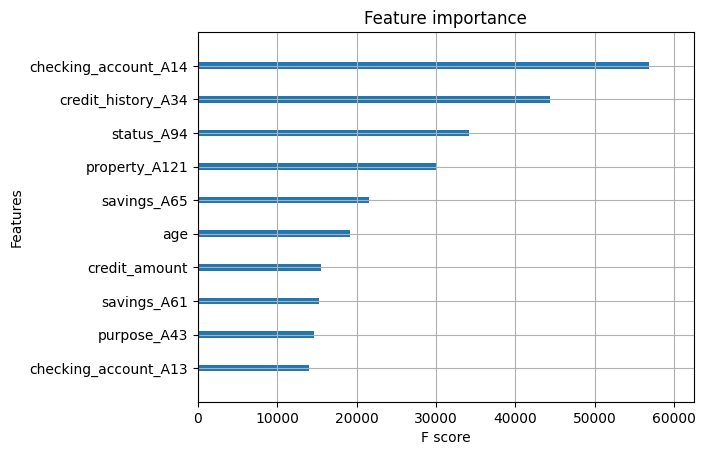

In [20]:
xgb.plot_importance(xgc, importance_type="gain", max_num_features=10, show_values=False);

Based on the above we see that the top three features driving the predictions of the model are:

* checking_account_A14 - lack of a checking account
* credit_history_A34 - critical account / has credits outside of the bank
* property_A121 - real estate

We could also look at the other importance metrics, just for completeness.

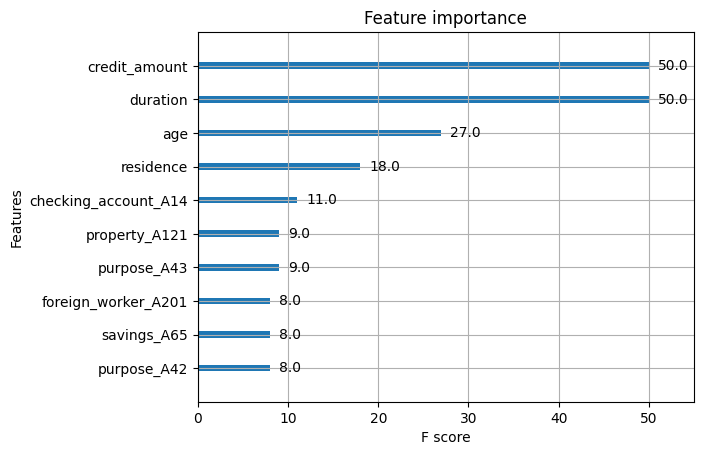

In [21]:
xgb.plot_importance(xgc, importance_type="weight", max_num_features=10);

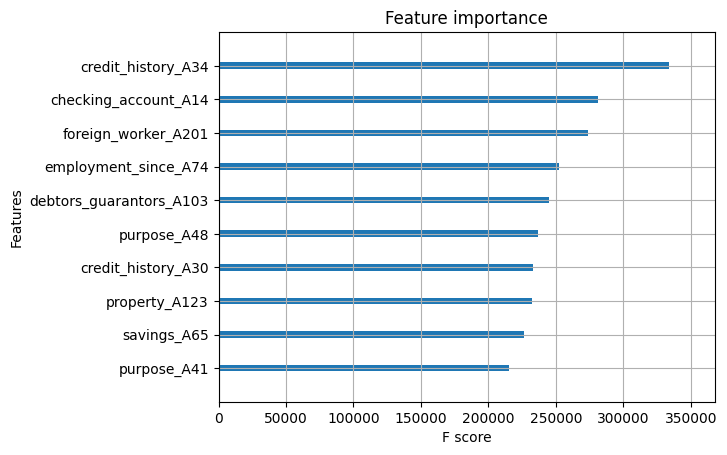

In [22]:
xgb.plot_importance(xgc, importance_type="cover", max_num_features=10, show_values=False);

ELI5 is another popular libarary for model explainability. This package is used to debug machine learning classifiers and explain their predictions. 

Unlike XGBoost, which is confined to explaining its own models only, ELI5 provides support for other frameworks like *scikit-learn*, *Keras*, *LightGBM* and others. It can also explain black-box models (i.e. Neural Networks) using [LIME](https://www.dominodatalab.com/blog/explaining-black-box-models-using-attribute-importance-pdps-and-lime).

First, ELI5 also provides a way of calculating the feature importance. Let's test it and make sure it agrees with the original XGBoost calculation (based on gain).

In [23]:
eli5.show_weights(xgc)

Weight,Feature
0.1014,checking_account_A14
0.0792,credit_history_A34
0.0609,status_A94
0.0536,property_A121
0.0385,savings_A65
0.0343,age
0.0278,credit_amount
0.0271,savings_A61
0.0261,purpose_A43
0.0251,checking_account_A13


A more interesting function is `show_predictions`, which returns an explanation of the decision behind individual predictions. In other words, we can see what features drove the model to predict one outcome or the other.

Feel free to experiment with the code below, changing the `id` value and observing what features the model uses to calculate its prediction, and if the prediction agrees with the actual value. The `id` variable represents an observation number from the test dataset.

In [24]:
id = 3 # <- change this to see results for different observations  

print("Actual Label: %s" % actuals.iloc[id])
print("Predicted: %s" % pred_class[id])
eli5.show_prediction(xgc, df_test_X.iloc[id], 
                     feature_names=list(df_test_X.columns),
                     show_feature_values=True)


Actual Label: 1
Predicted: 1


This concludes the model training notebook demo.

In [25]:
# Set some default values
column_names_all = ['duration', 'credit_amount', 'installment_rate', 'residence', 'age', 'credits', 'dependents', 'checking_account_A11', 'checking_account_A12', 'checking_account_A13', 'checking_account_A14', 'credit_history_A30', 'credit_history_A31',
                    'credit_history_A32', 'credit_history_A33', 'credit_history_A34', 'purpose_A40', 'purpose_A41', 'purpose_A410', 'purpose_A42', 'purpose_A43', 'purpose_A44', 'purpose_A45', 'purpose_A46', 'purpose_A48', 'purpose_A49', 'savings_A61', 
                    'savings_A62', 'savings_A63', 'savings_A64', 'savings_A65', 'employment_since_A71', 'employment_since_A72', 'employment_since_A73', 'employment_since_A74', 'employment_since_A75', 'status_A91', 'status_A92', 'status_A93', 'status_A94', 
                    'debtors_guarantors_A101', 'debtors_guarantors_A102', 'debtors_guarantors_A103', 'property_A121', 'property_A122', 'property_A123', 'property_A124', 'other_installments_A141', 'other_installments_A142', 'other_installments_A143', 'housing_A151', 
                    'housing_A152', 'housing_A153', 'job_A171', 'job_A172', 'job_A173', 'job_A174', 'telephone_A191', 'telephone_A192', 'foreign_worker_A201', 'foreign_worker_A202']

sample_data = [[0.4705882352941176, 0.3685484758446132, 0.3333333333333333, 0.3333333333333333, 
                0.2857142857142857, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 
                1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 
                1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 
                1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0]]

In [26]:
df_all = pd.DataFrame(sample_data, columns=column_names_all)

In [27]:
for col in ['checking_account_A11', 'checking_account_A12', 'checking_account_A13', 'checking_account_A14', 
                'credit_history_A30', 'credit_history_A31', 'credit_history_A32', 'credit_history_A33', 
                'credit_history_A34', 'purpose_A40', 'purpose_A41', 'purpose_A410', 'purpose_A42', 'purpose_A43', 
                'purpose_A44', 'purpose_A45', 'purpose_A46', 'purpose_A48', 'purpose_A49', 'savings_A61', 
                'savings_A62', 'savings_A63', 'savings_A64', 'savings_A65', 'employment_since_A71', 
                'employment_since_A72', 'employment_since_A73', 'employment_since_A74', 'employment_since_A75', 
                'status_A91', 'status_A92', 'status_A93', 'status_A94', 'debtors_guarantors_A101', 
                'debtors_guarantors_A102', 'debtors_guarantors_A103', 'property_A121', 'property_A122', 
                'property_A123', 'property_A124', 'other_installments_A141', 'other_installments_A142', 
                'other_installments_A143', 'housing_A151', 'housing_A152', 'housing_A153', 'job_A171', 'job_A172', 
                'job_A173', 'job_A174', 'telephone_A191', 'telephone_A192', 'foreign_worker_A201', 'foreign_worker_A202']:
    df_all[col] = df_all[col].astype('int')


In [28]:
eli5.show_prediction(xgc, df_all.iloc[0], 
                         feature_names=list(df_all.columns),
                         show_feature_values=True)

In [29]:
df_all.iloc[0]

duration               0.470588
credit_amount          0.368548
installment_rate       0.333333
residence              0.333333
age                    0.285714
                         ...   
job_A174               1.000000
telephone_A191         0.000000
telephone_A192         1.000000
foreign_worker_A201    1.000000
foreign_worker_A202    0.000000
Name: 0, Length: 61, dtype: float64

In [30]:
df_all.iloc[0]["checking_account_A14"]

0.0

In [31]:
df_prediction = eli5.explain_prediction_df(xgc, df_all.iloc[0], 
                         feature_names=list(df_all.columns))

In [32]:
df_prediction.head(10).style.background_gradient(cmap = "Greens").hide()

target,feature,weight,value
y,purpose_A41,0.655528,1.000000
y,age,0.579540,0.285714
y,credit_amount,0.348853,0.368548
y,telephone_A192,0.187726,1.000000
y,property_A123,0.157003,1.000000
y,status_A93,0.134142,1.000000
y,checking_account_A11,0.116792,0.000000
y,status_A92,0.103908,0.000000
y,employment_since_A73,0.060939,1.000000
y,employment_since_A72,0.056050,0.000000
